# Table of Contents

> The following script provides reproducible simulations for the results described in _"Updated and standardized genome-scale reconstruction of Mycobacterium tuberculosis H37Rv, iEK1011, simulates flux states indicative of physiological conditions"_. 

**IMPORTANT**: _the model has been updated to a BiGGs quality model named iEK1008. All simulations in this notebook utilize the model iEK1008 even though the variables state iEK1011._

1. [Load and check iEK1011](#iEK_model)
    - Check default media condition.
    - Check FBA solution.
    - Check mass balance.
    - Look at blocked reactions.
    
2. [Compute and Gene Essentiality Predictions](#gene_essentiality)
    - Calculate for Griffin dataset
    - Calculate for DeJesus dataset
    - Calculate using Zimmerman et. al. _in vivo_ approximations.
3. [Compare iEK1011 simulations between _in vivo_ and _in vitro_ media conditions](#media_comparisons)
    - First compute FVA in different media conditions for initial check.
    - Sample the solution space of the _in vitro_ iEK1011
    - Sample the solution space of the _in vivo_ iEK1011
    - Compare the sampled solutions using a box plot 
4. [Curated list of AMR genes for escher map](#amr_genes)
    - Provides json file for AMR genes that can be viewed at Escher (http://escher.github.io/). The maps provided in the supplementary material may be useful.
5. [Comparison of AMR objective function simulations between media conditions](#amr_objective_simulation)
6. [Save iEK1011 features and simulations to "iEK1011_supplementary.xlsx"](#save_model_to_supplementary)

---

In [1]:
import cobra
from cobra.manipulation import remove_genes
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import \
    single_gene_deletion, single_reaction_deletion, \
    double_gene_deletion, double_reaction_deletion
import math
import pandas as pd
import sys
import matplotlib.pyplot as plt
from cobra.flux_analysis import production_envelope
from cobra.flux_analysis import sample
import matplotlib
import numpy as np
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import json
import seaborn as sns

This notebook was run using cobra version 11.2

In [2]:
print cobra.__version__

0.11.2


### What you need to run this notebook...
1. _iEK1008_ in json format and located in the same folder as this notebook.
2. (OPTIONAL) Previous models for Venn diagram comparisons
3. Griffin Essentiality data and DeJesus essentiality data. 

# 1. *Load iEK1008*
Although the model is far from perfect, we believe that _iEK1008_ is a step in the right direction.

Growth rate should be around 0.0165 
<a id='iEK_model'></a>

In [72]:
recon_location = "iEK1008_BiGGs_reconstructions/"

In [73]:
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_m7H10_media.json")

In [74]:
print "# of reactions", len(model_iEK.reactions)
print "# of metabolites", len(model_iEK.metabolites)
print "# of genes", len(model_iEK.genes)

# of reactions 1226
# of metabolites 999
# of genes 1008


In [75]:
model_iEK.id

u'iEK1008'

In [76]:
model_iEK.optimize().f

0.016565861305413956

In [77]:
model_iEK.optimize().fluxes.sort_values()

EX_h       -4.846182
H2Ot       -2.924387
CO2t       -2.839099
EX_o2      -2.633219
SUCCt2r    -1.996182
KGD2       -1.824462
SUCOAS     -1.820518
EX_glu_L   -1.000000
EX_cit     -1.000000
NH4t       -0.886178
PTAr       -0.300309
EX_ac      -0.300092
ENO        -0.102487
GAPD       -0.081582
TPI        -0.034729
FBA        -0.032434
ASPTA      -0.026998
EX_pi      -0.022048
PGI        -0.012505
VALTA      -0.012166
RPE        -0.011738
RPI        -0.010575
VPAMTr     -0.008757
IMPC       -0.008291
TKT2       -0.006862
ASAD       -0.006192
PGAMT      -0.005469
DHORTS     -0.005118
ORPT       -0.005118
PGMT       -0.004878
              ...   
ME1         0.041389
PPA         0.056513
PGK         0.081582
PGM         0.102487
PEPCK_re    0.107194
NDPK1       0.111125
ACCOAC      0.111451
HCO3E       0.122737
MDH         0.134191
ICL         0.167585
MALS        0.167612
ACt2r_1     0.300092
ACKr        0.300309
ICDHy       0.832415
EX_nh4      0.886178
GLUDx       0.921420
GLUt2r      1

In [78]:
model_iEK.summary()

IN FLUXES           OUT FLUXES        OBJECTIVES
------------------  ----------------  ---------------
h_e       4.85      h2o_e   2.92      biomass  0.0166
o2_e      2.63      co2_e   2.84
cit_e     1         succ_e  2
glu__L_e  1         nh4_e   0.886
ac_e      0.3       4hba_e  1.33e-05
pi_e      0.022
so4_e     0.00221
fe3_e     9.28e-05


## Check default media condition
- Should be initalized to approximate Middlebrook 7H10 with Acetate as the carbon source as described in _Eoh and Rhee; PNAS 2014_. Although not used in this study, m7H10 with acetate has been used in numerous papers and thus provides a good media intialization.


In [79]:
model_iEK.medium

{u'EX_ac': 10,
 u'EX_btn': 1,
 u'EX_ca2': 1000.0,
 u'EX_cit': 1.0,
 u'EX_cl': 1000.0,
 u'EX_co2': 1000,
 u'EX_cu2': 1000.0,
 u'EX_fe2': 1000.0,
 u'EX_fe3': 1000.0,
 u'EX_glu_L': 1.0,
 u'EX_h': 1000,
 u'EX_h2co3': 1000,
 u'EX_k': 1000,
 u'EX_mg2': 1000.0,
 u'EX_mobd': 1000,
 u'EX_na1': 1000,
 u'EX_nh4': 20,
 u'EX_o2': 20,
 u'EX_pi': 1000,
 u'EX_pydxn': 1,
 u'EX_so4': 1000}

## Check FBA solution
Growth should be about 0.0165 mmol/g DW/ hr

In [80]:
model_iEK.optimize().f

0.016565861305413956

## Check Mass Balance
- Exchange reactions are not accounted for here.
- Biomass reactions are not accounted for here.
- Demand reactions are not accounted for here.

The list of these reactions are provided in **Supplementary Table 1**

In [81]:
# print len(cobra.manipulation.validate.check_mass_balance(model_iEK).keys())
mass_bal_metabs, mass_bal_reacts = [], []
for react_id, mass_bal in cobra.manipulation.validate.check_mass_balance(model_iEK).iteritems():
    
    # ------ Don't count exchange reactions and biomass functions -----
    if str(react_id)[:3]!="EX_" and "biomass" not in str(react_id) and str(react_id)[:3]!="DM_":
        rxn_metabs = [str(x.id) for x in model_iEK.reactions.get_by_id(react_id.id).metabolites]
        mass_bal_metabs.extend(rxn_metabs)
        mass_bal_reacts.append(str(react_id))
        print str(react_id), mass_bal, react_id.reaction, react_id.gene_reaction_rule

print "# of reactions not mass balanced -", len(mass_bal_reacts)

LIPY: 10.0 h2o_c + 9.0 tag_TB_c --> 9.0 12dgr_TB_c + arach_c + 2.0 hdca_c + 2.0 hexc_c + 4.0 ocdca_c {'H': -1.0, 'C': 5.0, 'O': -1.0} 10.0 h2o_c + 9.0 tag_TB_c --> 9.0 12dgr_TB_c + arach_c + 2.0 hdca_c + 2.0 hexc_c + 4.0 ocdca_c Rv3097c
MBTA1: acac_c + h_c + n6hlys_c + n6hlysmal_c + nadh_c + salc_c + thr__L_c --> 6.0 h2o_c + mcbtt_c + nad_c {'H': 32.0, 'C': 13, 'O': -2.0} acac_c + h_c + n6hlys_c + n6hlysmal_c + nadh_c + salc_c + thr__L_c --> 6.0 h2o_c + mcbtt_c + nad_c Rv2384 and Rv2383c and Rv2382c and Rv2381c and Rv2380c and Rv2379c and Rv2377c
NMO: etha_c + fmnh2_c + o2_c --> acald_c + fmn_c + no2_c {'H': -6.0} etha_c + fmnh2_c + o2_c --> acald_c + fmn_c + no2_c Rv0021c or Rv1533 or Rv1894c or Rv2781c or Rv3553
VIUB: atp_c + fe3_e + h2o_c + 0.0005 mcbts_c + 0.0005 mcbtt_c --> adp_c + fe3_c + pi_c {'H': -1.072000000000001, 'C': -0.04349999999999987, 'O': -0.010000000000001563, 'N': -0.005000000000000782} atp_c + fe3_e + h2o_c + 0.0005 mcbts_c + 0.0005 mcbtt_c --> adp_c + fe3_c + pi_c

## Look at Blocked Reactions
Note that it's ok for many reactions to be blocked because the pathway may be incomplete or the ending metabolite has no way to leave the system.

In [82]:
blocked_reacts = cobra.flux_analysis.variability.find_blocked_reactions(model_iEK, 
                                                                        reaction_list=None, 
                                                                        zero_cutoff=1e-09, 
                                                                        open_exchanges=True)
print len(blocked_reacts)

232


## Compare to previous models. (OPTIONAL)
- This section of the worfklow will require access to the previous models.
    - Note: I've renamed the raw model files downloaded from the supplementary to different names.

In [83]:
# this is the sMtb model that is mapped to BIGGs identifiers.
# the xml model in sMtb paper can't compute as shown below.

### --- Running the following code results in "infeasible" 
# model_sMtb_original = cobra.io.read_sbml_model("TB_previous_models/sMtb_sbml_3.xml")
# model_sMtb_original.optimize()

model_sMtb_mapped = cobra.io.load_json_model("TB_previous_models/sMtb_mapped_model.json")
model_sMtb_mapped.metabolites.get_by_id("tdm3_c ").id = "tdm3_c"
model_sMtb_mapped.repair()
cobra.io.save_json_model(model_sMtb_mapped, "sMtb_mapped_model.json")

model_iOSDD = cobra.io.load_matlab_model("TB_previous_models/iOSDD.mat")

# model_iSM810 = cobra.io.load_matlab_model("TB_previous_models/MTB_iSM810_COBRA.mat")
model_iSM810 = cobra.io.read_sbml_model("TB_previous_models/MTB_iSM810_media7H9.xml")

# the following fixes enable gene essentiality tests
model_iSM810.reactions.get_by_id("R157").gene_reaction_rule = "Rv0855"

# initial media conditions of iSM810
print model_iSM810.medium

model_iNJ661 = cobra.io.load_json_model("TB_previous_models/iNJ661.json")
model_galagan = cobra.io.read_sbml_model("TB_previous_models/Galagan2015.xml")

model_iEK1032old = cobra.io.load_json_model("TB_previous_models/iEK1032_old.json")

cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3302c OR Rv2249c
					' for '<Reaction R4 at 0x134bb6f90>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv2858c OR Rv0458 
					' for '<Reaction R5 at 0x14a4ef710>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3257c OR Rv3308
					' for '<Reaction R12 at 0x134bb70d0>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv0112 OR Rv1511
					' for '<Reaction R15 at 0x134bb7690>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv0619 OR Rv0618
					' for '<Reaction R19 at 0x134bb78d0>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3634c OR Rv0501 OR Rv0536
					' for '<Reaction R20 at 0x134bb7990>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv0046c OR Rv2612c AND Rv1822
					' for '<Reaction R22 at 0x134bb7b90>'
cobra/core/reaction.py:388 UserWarning: uppercase

cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv2243 OR Rv0649 AND Rv2244
					' for '<Reaction R496 at 0x129b90950>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3280 AND Rv3799c AND Rv3285
					' for '<Reaction R508 at 0x12a5fd250>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv2243 OR Rv0649 AND Rv2244
					' for '<Reaction R509 at 0x12a5fd350>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv2243 OR Rv0649 AND Rv2244
					' for '<Reaction R510 at 0x12a5fd490>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv2243 OR Rv0649 AND Rv2244
					' for '<Reaction R511 at 0x12a5fd290>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv2243 OR Rv0649 AND Rv2244
					' for '<Reaction R512 at 0x12a5fd590>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv2243 OR Rv0649 AND Rv2244
					' for '<Reaction R513 at 0x12

cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3570c AND Rv3567c
					' for '<Reaction R937 at 0x138255450>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3502c AND Rv3538 AND Rv3504 AND Rv3505 AND Rv3506 AND Rv3515c AND Rv3516 AND Rv3522 AND Rv3523
					' for '<Reaction R940 at 0x138255390>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3569c AND Rv3534c AND Rv3535c AND Rv3536c
					' for '<Reaction R941 at 0x138255490>'


{'R800': 1.0, 'R812': 1.0, 'R925': 1.0, 'R804': 1.0, 'R805': 1000.0}


cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3502c AND Rv3538 AND Rv3504 AND Rv3505 AND Rv3506 AND Rv3515c AND Rv3516 AND Rv3522 AND Rv3523' for '<Reaction R940 at 0x11e78d390>'
cobra/core/reaction.py:388 UserWarning: uppercase AND/OR found in rule 'Rv3569c AND Rv3534c AND Rv3535c AND Rv3536c' for '<Reaction R941 at 0x11e769510>'


In [84]:
len(model_iEK1032old.genes)

1023

Load genes annotated with reactions from BioCyc database.

In [85]:
# First I need to get all the genes from the BioCyc model.
# Before 1165 w/ AllReactions_Genes_H37Rv_(2016)
csv_file = "TB_previous_models/BioCyc2016.csv"
bioCyc_data = pd.read_csv(csv_file)
print len(bioCyc_data["Reactions"])
bioCyc_genes = []
for i in bioCyc_data["Accession-1"]:
    if str(i) != "nan":
        if "//" in str(i):
            x = i.split(" // ")
            x = [w.replace("\"", '') for w in x]
            bioCyc_genes.extend(x)
        else:
            bioCyc_genes.append(i)
bioCyc_genes = set(bioCyc_genes)
print len(bioCyc_genes)

1698
1166


In [86]:
iEK1011_genes = [str(x) for x in model_iEK.genes]
print "iEK1011", len(iEK1011_genes)

print "BioCyc", len(bioCyc_genes)

sMtb_genes = [str(x) for x in model_sMtb_mapped .genes]
print "sMtb", len(sMtb_genes)

iNJ661_genes = [str(x) for x in model_iNJ661.genes]
print "iNJ661", len(iNJ661_genes)

galagan_genes = [str(x) for x in model_galagan.genes]
print "galgan2015", len(galagan_genes)

iOSDD_genes = [str(x) for x in model_iOSDD.genes]
print "iOSDD", len(iOSDD_genes)

iSM810_genes = [str(x) for x in model_iSM810.genes]
print "iSM810", len(iSM810_genes)

iEK1011 1008
BioCyc 1166
sMtb 915
iNJ661 661
galgan2015 760
iOSDD 889
iSM810 809


#### Models based on GSMN-TB 1.1

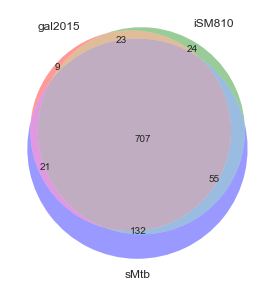

In [87]:
plt.figure(figsize=(5, 5))
v = venn3([set(galagan_genes), set(iSM810_genes), set(sMtb_genes)], ('gal2015', 'iSM810', 'sMtb'))
# plt.savefig("venn_galagan2015_iSM810_sMtb.svg")
plt.show()

#### Models based on iNJ661

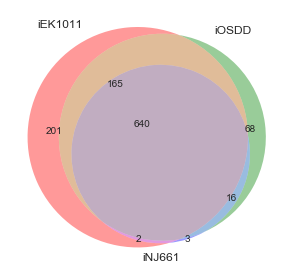

In [88]:
plt.figure(figsize=(5, 5))
venn3([set(iEK1011_genes), set(iOSDD_genes), set(iNJ661_genes)], ('iEK1011', 'iOSDD', 'iNJ661'))
# plt.savefig("venn_iEK_iOSDD_iNJ661.svg")
plt.show()

#### Overlap of new recon and base reconstruction models

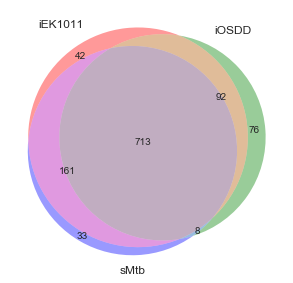

In [89]:
plt.figure(figsize=(5, 5))
venn3([set(iEK1011_genes), set(iOSDD_genes), set(sMtb_genes)], ('iEK1011', 'iOSDD', 'sMtb'))
# plt.savefig("venn_iEK_iOSDD_sMtb.svg")
plt.show()

### Genes not in iEK1011

In [90]:
all_previous_genes = list(set(iOSDD_genes + iNJ661_genes + galagan_genes + iSM810_genes + sMtb_genes))
all_not_in_iEK = [x for x in all_previous_genes if x not in iEK1011_genes]

In [91]:
all_not_in_iEK_toModel_dict = {}
for x in all_not_in_iEK:
    
    gene_models = []
    if x in iOSDD_genes:
        gene_models.append("iOSDD")
        
    if x in iNJ661_genes:
        gene_models.append("iNJ661")
        
    if x in galagan_genes:
        gene_models.append("gal2015")
        
    if x in iSM810_genes:
        gene_models.append("iSM810")
        
    if x in sMtb_genes:
        gene_models.append("sMtb")
        
    all_not_in_iEK_toModel_dict.update({x: gene_models})
    
genes_notiEK_inPrevious_df = pd.DataFrame.from_dict(all_not_in_iEK_toModel_dict, orient="index")
print "genes in previous models not in iEK1011", len(all_not_in_iEK)

genes in previous models not in iEK1011 153


In [92]:
all_genes_AllModels = list(set(all_previous_genes + iEK1011_genes))
print "len(all_genes_AllModels): ", len(all_genes_AllModels)
all_shared_genes = []
for x in all_genes_AllModels:
    if x in iEK1011_genes: 
        if x in iOSDD_genes:
            if x in iNJ661_genes:
                if x in galagan_genes:
                    if x in iSM810_genes:
                        if x in sMtb_genes:
        
                            all_shared_genes.append(x)
            
print "len(all_shared_genes): ", len(all_shared_genes)

len(all_genes_AllModels):  1161
len(all_shared_genes):  473


In [93]:
growth_rates = single_gene_deletion(model_iEK)
print "Optimal growth", model_iEK.optimize().f

Optimal growth 0.0165658613084


In [94]:
growth_rates.head()

,growth,status
ids,,
(Rv0413),1.656586e-02,optimal
(Rv3480c),1.656586e-02,optimal
(Rv0729),1.656586e-02,optimal
(Rv0728c),4.526322e-12,optimal
(Rv1659),1.845079e-12,optimal


# Look at GAM and NGAM

Non-growth associated maintenance is expressed as a conversion of ATP to ADP and quantifies the energy required by Mtb to maintain itself in a given environment. For sMtb the NGAM and GAM were 0.1 mmol gdw-1h-1 and 57 mmol gdw-1.

For iEK1011, the growth associated maintence (GAM) was chosen to be $60 mmol gDw^-1$, which was the same as that used in iNJ661, iAB, and iOSDD. For comparison, the GAM value for sMtb was 57.

In [95]:
model_iEK.reactions.get_by_id("biomass").reaction

'0.2352 14glucan_c + 0.001681 Ac1PIM1_c + 0.001488 Ac1PIM2_c + 0.001335 Ac1PIM3_c + 0.001211 Ac1PIM4_c + 0.001274 Ac2PIM2_c + 0.001573 PIM3_c + 0.001403 PIM4_c + 0.001266 PIM5_c + 0.001154 PIM6_c + 0.23018 acgam1p_c + 0.40596 ala__L_c + 0.0347 amet_c + 0.000731 arabinanagalfragund_c + 0.015676 arach_c + 0.12042 arg__L_c + 0.047699 asn__L_c + 0.12031 asp__L_c + 60.0 atp_c + 0.0295 c78mycolatepp_c + 0.005859 clpn160190_c + 0.25095 cmp_c + 0.0132 coa_c + 0.0168 ctp_c + 0.022 cys__L_c + 0.003492 damp_c + 0.0102 datp_c + 0.0194 dctp_c + 0.0194 dgtp_c + 0.0102 dttp_c + 0.0129 fad_c + 0.0008 fdxox_c + 0.0008 fdxrd_c + 0.0008 fe2_c + 0.0008 fe3_c + 0.0222 fmn_c + 0.0001 gdpmann_c + 0.16315 glc__D_c + 0.05812 gln__L_c + 0.090007 glu__L_c + 0.33581 gly_c + 0.0184 glyc_c + 0.2352 glycogen_c + 0.24365 gmp_c + 0.0168 gtp_c + 60.0 h2o_c + 0.23515 hdca_c + 0.01094 hdcea_c + 0.0008 hemeA_c + 0.0008 hemeO_c + 0.058352 hexc_c + 0.074917 his__L_c + 0.0064 hphthiocnylcoa_c + 0.087731 ile__L_c + 0.20471 le

In [96]:
model_iOSDD.reactions.get_by_id("biomass_Mtb_9_60atp").reaction

'0.001681 Ac1PIM1[c] + 0.001488 Ac1PIM2[c] + 0.001335 Ac1PIM3[c] + 0.001211 Ac1PIM4[c] + 0.001274 Ac2PIM2[c] + 0.002076 PIM1[c] + 0.00179 PIM2[c] + 0.001573 PIM3[c] + 0.001403 PIM4[c] + 0.001266 PIM5[c] + 0.001154 PIM6[c] + 0.23018 acgam1p[c] + 0.40596 ala-L[c] + 0.13903 amp[c] + 0.000731 arabinanagalfragund[c] + 0.015676 arach[c] + 0.12042 arg-L[c] + 0.047699 asn-L[c] + 0.12031 asp-L[c] + 60.0 atp[c] + 0.005859 clpn160190[c] + 0.25095 cmp[c] + 0.022 cys-L[c] + 0.003492 damp[c] + 0.006663 dcmp[c] + 0.006659 dgmp[c] + 0.003653 dtmp[c] + 0.001498 fcmcbtt[c] + 0.055474 gal[c] + 0.16315 glc-D[c] + 0.05812 gln-L[c] + 0.090007 glu-L[c] + 0.33581 gly[c] + 0.025359 glyc[c] + 0.24365 gmp[c] + 60.0 h2o[c] + 0.23515 hdca[c] + 0.01094 hdcea[c] + 0.058352 hexc[c] + 0.040617 his-L[c] + 0.087731 ile-L[c] + 0.003338 kmycolate[c] + 0.20471 leu-L[c] + 0.03909 lys-L[c] + 0.095065 man[c] + 0.00784 mbhn[c] + 0.001402 mcbts[c] + 0.034889 met-L[c] + 0.001184 mfrrppdima[c] + 0.003291 mkmycolate[c] + 0.003365 

In [97]:
print model_iEK.reactions.get_by_id("ATPM").lower_bound

3.15


# 2. *Gene Essentiality*
In order to run the following gene essentiality predictions, load both the griffin and jesus gene essentiality excel sheet.
<a id='gene_essentiality'></a>

**Griffin**: minimal media (asparagine 0.5 g/L, KH2PO4 1.0 g/L, Na2HPO4 2.5 g/L ferric ammonium citrate 50 mg/L, MgSO4 ?7H20 0.5 g/ L, CaCl2 0.5 g/L, ZnSO4 0.1 mg/L), 25 mg/ml Kanamycin, 0.2% tyloxapol, 0.2% ethanol and either 0.1% glycerol or 0.01% cholesterol.

In [98]:
griffin_file = "Dataframes/Table_S2.xlsx"
griffin_excel = pd.read_excel(griffin_file,  sheetname='supp table 2',skiprows = 9,keep_default_na=False)

**DeJesus**: While Griffin used minimal media plus glycerol, our replicates were grown on rich media (7H9 or 7H10 [7H9/10] plus oleic acid-albumin-dextrose-catalase [OADC]) with a variety of potential carbon sources available (glycerol, dextrose, oleate, citrate, and glutamate)

In [99]:
loerger_file = "Dataframes/inline-supplementary-material-5.xlsx"
loerger_excel = pd.read_excel(loerger_file,  sheetname='ORF Essentiality Calls',
                              skiprows = 1,keep_default_na=False)
loerger_excel["Locus"] = loerger_excel["ORF ID"].map(lambda x: x.strip())
# only look at genes labeled with RvXXXX
# loerger_excel = loerger_excel.loc[:1521]
# loerger_excel["Locus"] = loerger_excel["ID"].map(lambda x: x.split("-")[1].strip())

In [100]:
def essen_test(model_tb, dic_return, dataset_name, dataset_excel, growth_thresh_mult):
    model = model_tb.copy()
    
    fal_pos_dic, fal_neg_dic = {}, {}
    true_neg_dic, true_pos_dic = {}, {}
    
    growth_rates = single_gene_deletion(model)
    growth_rates.index = growth_rates.index.map(lambda x: list(set(x))[0].strip("(").strip(")"))
    print "Optimal growth", model.optimize().f
    
    orig_growth_thres = growth_thresh_mult*model.optimize().f
    print "Threshold growth", orig_growth_thres
    
    true_pos, true_neg, fal_pos, fal_neg = 0, 0, 0, 0
    
    # set grif essen threshold -- iSM810 paper uses 0.1 as "confident essential"
    grif_thres = 0.1
        
    for index, row in dataset_excel.iterrows():
        gene = str(row["Locus"])
        # print gene
        
        if dataset_name == "griffin":
            
            try:
                growth = growth_rates.loc[gene, "growth"]

                # True Positive - predicts that it grows (not essential) and is correct.
                if float(row["p value"]) > grif_thres and growth > orig_growth_thres:
                    true_pos = true_pos + 1
                    true_pos_dic.update({gene: [growth, float(row["p value"])]})

                # False Positive - predicts that it grows (not essential) when it actually essential
                if float(row["p value"]) < grif_thres and growth > orig_growth_thres:
                    fal_pos = fal_pos + 1
                    fal_pos_dic.update({gene: [growth, float(row["p value"])]})
                
                # True Negative - predicts that the gene is essential (no growth) and is correct
                if float(row["p value"]) < grif_thres and growth < orig_growth_thres:
                    true_neg = true_neg + 1
                    true_neg_dic.update({gene: [growth, float(row["p value"])]})

                if float(row["p value"]) > grif_thres and growth < orig_growth_thres:
                    fal_neg = fal_neg + 1
                    fal_neg_dic.update({gene: [growth, float(row["p value"])]})
                    
                    
            except:
                # print "something messed up"
                pass
                        
        elif dataset_name == "loerger":
            """
            ES being near 0
            NE being near the mean
            GD approximately 1/10 the mean
            GA 5 times the mean
            """
            try:
                growth = growth_rates.loc[gene, "growth"]
                
                # TP
                if (row["Final Call"] == "NE" or row["Final Call"] == "GA") and growth > orig_growth_thres:
                    true_pos = true_pos + 1
                    true_pos_dic.update({gene: [growth]})
                        
                # FN
                if (row["Final Call"] == "NE" or row["Final Call"] == "GA") and growth < orig_growth_thres:
                    fal_neg = fal_neg + 1
                    fal_neg_dic.update({gene: [growth]})
                        
                # TN
                if (row["Final Call"] == "ES" or row["Final Call"] == "ESD" or row["Final Call"] == "GD") and growth < orig_growth_thres:
                # if (row["Final Call"] == "ES") and growth < orig_growth_thres:
                    true_neg = true_neg + 1
                    true_neg_dic.update({gene: [growth]})
                        
                # FP
                if (row["Final Call"] == "ES" or row["Final Call"] == "ESD" or row["Final Call"] == "GD") and growth > orig_growth_thres:
                # if (row["Final Call"] == "ES") and growth > orig_growth_thres:
                    fal_pos = fal_pos + 1
                    fal_pos_dic.update({gene: [growth]})
            except:
                pass
                
            
    # ---Analyze and Print results ---
    print "TP - TN - FP - FN"
    print true_pos, true_neg, fal_pos, fal_neg
    
    # percent of correct predictions
    perc_correct = (true_pos+true_neg)/(true_pos+true_neg+fal_pos+float(fal_neg))
    print "percent correct: ", perc_correct
    
    # mcc calculation
    MCC_root = math.sqrt((true_pos + fal_pos)*(true_pos + fal_neg)*(true_neg + fal_pos)*(true_neg + fal_neg))
    MCC = (true_pos*true_neg - fal_pos*fal_neg)/MCC_root
    print "Matthew Correlation Coefficient", MCC
    if dic_return == "Yes":
        return fal_neg_dic, fal_pos_dic
    elif dic_return == "Yes both":
        return fal_neg_dic, fal_pos_dic, true_neg_dic, true_pos_dic
    


def essen_test_sharedGenes(model_tb, dic_return, dataset_name, dataset_excel, growth_thresh_mult, all_shared_genes):
    model = model_tb.copy()
    
    fal_pos_dic, fal_neg_dic = {}, {}
    true_neg_dic, true_pos_dic = {}, {}
    
    growth_rates = single_gene_deletion(model)
    growth_rates.index = growth_rates.index.map(lambda x: list(set(x))[0].strip("(").strip(")"))
    print "Optimal growth", model.optimize().f
    
    orig_growth_thres = growth_thresh_mult*model.optimize().f
    print "Threshold growth", orig_growth_thres
    
    true_pos, true_neg, fal_pos, fal_neg = 0, 0, 0, 0
    
    # set grif essen threshold -- iSM810 paper uses 0.1 as "confident essential"
    grif_thres = 0.1
    
    growth_rates = growth_rates.loc[all_shared_genes, ].copy()
    
        
    for index, row in dataset_excel.iterrows():
        gene = str(row["Locus"])
        # print gene
        
        if dataset_name == "griffin":
            
            try:
                growth = growth_rates.loc[gene, "growth"]

                # True Positive - predicts that it grows (not essential) and is correct.
                if float(row["p value"]) > grif_thres and growth > orig_growth_thres:
                    true_pos = true_pos + 1
                    true_pos_dic.update({gene: [growth, float(row["p value"])]})

                # False Positive - predicts that it grows (not essential) when it actually essential
                if float(row["p value"]) < grif_thres and growth > orig_growth_thres:
                    fal_pos = fal_pos + 1
                    fal_pos_dic.update({gene: [growth, float(row["p value"])]})
                
                # True Negative - predicts that the gene is essential (no growth) and is correct
                if float(row["p value"]) < grif_thres and growth < orig_growth_thres:
                    true_neg = true_neg + 1
                    true_neg_dic.update({gene: [growth, float(row["p value"])]})

                if float(row["p value"]) > grif_thres and growth < orig_growth_thres:
                    fal_neg = fal_neg + 1
                    fal_neg_dic.update({gene: [growth, float(row["p value"])]})
                    
                    
            except:
                # print "something messed up"
                pass
                        
        elif dataset_name == "loerger":
            """
            ES being near 0
            NE being near the mean
            GD approximately 1/10 the mean
            GA 5 times the mean
            """
            try:
                growth = growth_rates.loc[gene, "growth"]
                
                # TP
                if (row["Final Call"] == "NE" or row["Final Call"] == "GA") and growth > orig_growth_thres:
                    true_pos = true_pos + 1
                    true_pos_dic.update({gene: [growth]})
                        
                # FN
                if (row["Final Call"] == "NE" or row["Final Call"] == "GA") and growth < orig_growth_thres:
                    fal_neg = fal_neg + 1
                    fal_neg_dic.update({gene: [growth]})
                        
                # TN
                if (row["Final Call"] == "ES" or row["Final Call"] == "ESD" or row["Final Call"] == "GD") and growth < orig_growth_thres:
                # if (row["Final Call"] == "ES") and growth < orig_growth_thres:
                    true_neg = true_neg + 1
                    true_neg_dic.update({gene: [growth]})
                        
                # FP
                if (row["Final Call"] == "ES" or row["Final Call"] == "ESD" or row["Final Call"] == "GD") and growth > orig_growth_thres:
                # if (row["Final Call"] == "ES") and growth > orig_growth_thres:
                    fal_pos = fal_pos + 1
                    fal_pos_dic.update({gene: [growth]})
            except:
                pass
                
            
    # ---Analyze and Print results ---
    print "TP - TN - FP - FN"
    print true_pos, true_neg, fal_pos, fal_neg
    
    # percent of correct predictions
    perc_correct = (true_pos+true_neg)/(true_pos+true_neg+fal_pos+float(fal_neg))
    print "percent correct: ", perc_correct
    
    # mcc calculation
    MCC_root = math.sqrt((true_pos + fal_pos)*(true_pos + fal_neg)*(true_neg + fal_pos)*(true_neg + fal_neg))
    MCC = (true_pos*true_neg - fal_pos*fal_neg)/MCC_root
    print "Matthew Correlation Coefficient", MCC
    if dic_return == "Yes":
        return fal_neg_dic, fal_pos_dic
    elif dic_return == "Yes both":
        return fal_neg_dic, fal_pos_dic, true_neg_dic, true_pos_dic

Change media

In [101]:
griffin_media = {
    "EX_h": 1000, # hydrogen
    "EX_h2o": 1000, # water
    "EX_o2": 20.0, # oxygen
    "EX_asn_L": 1.0, # asparagine
    "EX_nh4": 10.0, # ammonium
    "EX_cit":1.0, # citrate
    "EX_etoh": 1.0, # ethanol
    "EX_ca2": 1000.0, # calcium for CaCl2
    "EX_cl": 1000.0, # chloride for CaCl2
    "EX_mg2": 1000.0, # mg for MgSO4
    "EX_so4": 1000, # so4 for MgSO4
    "EX_fe3":5.0, # fe3 for ferric
    "EX_glyc":1.0, # glycerol
    "EX_pi":1.0, # phosphate
    "EX_chsterol":1.0, # cholesterol
}

griffin_media_iOSDD= {'EX_ca2(e)': 1.0,'EX_cit(e)': 1.0,'EX_cl(e)': 1.0,'EX_cu2(e)': 1.0,'EX_fe3(e)': 1.0,
                        'EX_asn_L(e)': 1.0,'EX_glyc(e)': 1.0,'EX_h(e)': 1.0,'EX_h2co3(e)': 1000.0,
                        'EX_h2o(e)': 1.0,'EX_k(e)': 1.0,'EX_na1(e)': 1.0,'EX_nh4(e)': 1.0,'EX_o2(e)': 0.98,
                        'EX_pi(e)': 1.0,'EX_so4(e)': 1.0}

griffin_media_iNJ661= {u'EX_ca2_e': 1.0,u'EX_cit_e': 1.0,u'EX_cl_e': 1.0,u'EX_cu2_e': 1.0,u'EX_fe3_e': 1.0,
                         u'EX_asn__L_e': 1.0,u'EX_glyc_e': 1.0,u'EX_h2co3_e': 999999.0,u'EX_h2o_e': 1.0,
                         u'EX_h_e': 1.0,u'EX_k_e': 1.0,u'EX_na1_e': 1.0,u'EX_nh4_e': 1.0,u'EX_o2_e': 1.0,
                         u'EX_pi_e': 1.0,u'EX_so4_e': 1.0}

griffin_media_sMtb = {u'EX_cit': 1.0,u'EX_fe2': 1.0,u'EX_fe3': 1.0,u'EX_asn': 1.0, u'EX_glyc': 1.0,
                    u'EX_glu__L': 0.01, # little glutamate here but really shouldnt. Necessary for sMtb
                     u'EX_h': 1.0,u'EX_ca2': 1.0,u'EX_h2o': 1.0,u'EX_k': 1.0,u'EX_nh3': 1.0,u'EX_o2': 1.0,
                     u'EX_pi': 1.0,u'EX_so4': 1.0,u'EX_mg2': 1.0,u'EX_chsterol': 1.0}

# iSM810 doesnt have water (No H2O)
griffin_media_iSM810 = {'R858': 1.0, # exchange for ethanol
                        'R924': 1.0, # exchange for citrate + Fe3
                        'R823': 1.0, # ATP -> ADP + ASP + PI ... Asparagine
                        'R932': 1.0, # --> CHOLESTEROL_c ... Cholesterol
                        'R800': 1.0, # <=> NH3_c ... ammonia
                        'R804': 1.0, # <=> O2_c .... oxygen
                        # 'R805': 1000.0, 
                        'R812': 1.0, # --> GL_c ... Glycerol
                        }

### Compare essentiality scores across models for 2011 data

In [102]:
model_sMtb_mapped.solver = "gurobi"
model_iEK.solver = "gurobi"
model_iSM810.solver = "gurobi"

In [103]:
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_griffinEssen_media.json")

In [104]:
model_iOSDD.medium = griffin_media_iOSDD
model_iNJ661.medium = griffin_media_iNJ661

# model_sMtb_mapped.medium = griffin_media_sMtb
# model_iSM810.medium = {}
# model_iSM810.medium = griffin_media_iSM810

> **sMtb** and **iSM810** are unable to simulate the gene deletions with the Griffin media conditions defined above. The values generated below are therefore dependent upon the initial media conditions given by the model. These values are close to those determined in their respective studies (.52 for iSM810 and .52 for sMtb).

Calculate the Matthews correlation coefficient. It should be around **0.60** for iEK1011 on the Griffin dataset.  

Comment out the previous models if they were not loaded in the previous optional section above.

In [105]:
grow_thresh = .2
print "iEK1008"
FN_dic_iEK, FP_dic_iEK, TN_dic_iEK, TP_dic_iEK = essen_test(model_iEK, "Yes both", "griffin", griffin_excel, grow_thresh)
print 
print "sMtb"
FN_dic_Mtb, FP_dic_Mtb, TN_dic_Mtb, TP_dic_Mtb = essen_test(model_sMtb_mapped, "Yes both", "griffin", griffin_excel, grow_thresh)
print 
print "iSM810"
FN_dic_iSM810, FP_dic_iSM810, TN_dic_iSM810, TP_dic_iSM810 = essen_test(model_iSM810, "Yes both", "griffin", griffin_excel, grow_thresh)
print 
print "iOSDD"
FN_dic_iOSDD, FP_dic_iOSDD, TN_dic_iOSDD, TP_dic_iOSDD = essen_test(model_iOSDD, "Yes both", "griffin", griffin_excel, grow_thresh)
print 
print "iNJ661"
FN_dic_iNJ661, FP_dic_iNJ661, TN_dic_iNJ661, TP_dic_iNJ661 = essen_test(model_iNJ661, "Yes both", "griffin", griffin_excel, grow_thresh)

iEK1008
Optimal growth 0.0581738729897
Threshold growth 0.0116347745979
TP - TN - FP - FN
577 231 160 31
percent correct:  0.808808808809
Matthew Correlation Coefficient 0.59895401932

sMtb
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0463072145249
Threshold growth 0.00926144290498
TP - TN - FP - FN
470 234 151 59
percent correct:  0.770240700219
Matthew Correlation Coefficient 0.525035599879

iSM810
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0258905585415
Threshold growth 0.00517811170831
TP - TN - FP - FN
402 191 175 35
percent correct:  0.738480697385
Matthew Correlation Coefficient 0.489251095307

iOSDD
Optimal growth 0.0334583132244
Threshold growth 0.00669166264488
TP - TN - FP - FN
434 138 267 47
percent corre

Compute for the 472 shared genes

In [106]:
grow_thresh = .2 
print "iEK1008"
FN_dic_iEK, FP_dic_iEK, TN_dic_iEK, TP_dic_iEK = essen_test_sharedGenes(model_iEK, "Yes both", "griffin", griffin_excel, grow_thresh, all_shared_genes)
print 
print "sMtb"
FN_dic_Mtb, FP_dic_Mtb, TN_dic, TP_dic = essen_test_sharedGenes(model_sMtb_mapped, "Yes both", "griffin", griffin_excel, grow_thresh, all_shared_genes)
print 
print "iSM810"
FN_dic_iSM810, FP_dic_iSM810, TN_dic, TP_dic = essen_test_sharedGenes(model_iSM810, "Yes both", "griffin", griffin_excel, grow_thresh, all_shared_genes)
print 
print "iOSDD"
FN_dic, FP_dic, TN_dic, TP_dic = essen_test_sharedGenes(model_iOSDD, "Yes both", "griffin", griffin_excel, grow_thresh, all_shared_genes)
print 
print "iNJ661"
FN_dic, FP_dic, TN_dic, TP_dic = essen_test_sharedGenes(model_iNJ661, "Yes both", "griffin", griffin_excel, grow_thresh, all_shared_genes)

iEK1008
Optimal growth 0.0581738729897
Threshold growth 0.0116347745979
TP - TN - FP - FN
158 201 85 21
percent correct:  0.772043010753
Matthew Correlation Coefficient 0.570349490092

sMtb
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0463072145249
Threshold growth 0.00926144290498
TP - TN - FP - FN
152 197 95 29
percent correct:  0.737843551797
Matthew Correlation Coefficient 0.500564245416

iSM810
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0258905585415
Threshold growth 0.00517811170831
TP - TN - FP - FN
154 178 114 27
percent correct:  0.701902748414
Matthew Correlation Coefficient 0.4515839136

iOSDD
Optimal growth 0.0334583132244
Threshold growth 0.00669166264488
TP - TN - FP - FN
148 122 170 33
percent correct:

### Compare essentiality scores for new 2017 Loerger data

In [107]:
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_deJesusEssen_media.json")

Calculate the Matthews Correlation Coefficient for iEK1011, it should be around **0.71**. Also, the gene essentiality scores are around **0.72** if the Griffin media is used. This can be seen if the Griffin initialized iEK1011 model is loaded first.

In [108]:
grow_thresh = .3
print "iEK1008----"
FN_dic_iEK, FP_dic_iEK, TN_dic_iEK, TP_dic_iEK = essen_test(model_iEK, "Yes both", "loerger", loerger_excel, grow_thresh)
print 
print "sMtb----"
FN_dic_sMtb, FP_dic_sMtb, TN_dic_sMtb, TP_dic_sMtb = essen_test(model_sMtb_mapped, "Yes both", "loerger", loerger_excel, grow_thresh)
print 
print "iSM810----"
FN_dic_iSM810, FP_dic_iSM810, TN_dic_iSM810, TP_dic_iSM810 = essen_test(model_iSM810, "Yes both", "loerger", loerger_excel, grow_thresh)
print 
print "iOSDD----"
FN_dic_iOSDD, FP_dic_iOSDD, TN_dic_iOSDD, TP_dic = essen_test(model_iOSDD, "Yes both", "loerger", loerger_excel, grow_thresh)
print 
print "iNJ661----"
FN_dic_iNJ661, FP_dic_iNJ661, TN_dic_iNJ661, TP_dic_iNJ661 = essen_test(model_iNJ661, "Yes both", "loerger", loerger_excel, grow_thresh)

iEK1008----
Optimal growth 0.0485359370679
Threshold growth 0.0145607811204
TP - TN - FP - FN
666 216 72 45
percent correct:  0.882882882883
Matthew Correlation Coefficient 0.708035871198

sMtb----
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0463072145249
Threshold growth 0.0138921643575
TP - TN - FP - FN
523 207 76 107
percent correct:  0.799561883899
Matthew Correlation Coefficient 0.546786962935

iSM810----
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0258905585415
Threshold growth 0.00776716756246
TP - TN - FP - FN
477 181 99 44
percent correct:  0.821473158552
Matthew Correlation Coefficient 0.596228639696

iOSDD----
Optimal growth 0.0334583132244
Threshold growth 0.0100374939673
TP - TN - FP - FN
512 124 186 61


Compute for 472 genes shared by all models

In [109]:
grow_thresh = .2
print "iEK1008----"
FN_dic_iEK, FP_dic_iEK, TN_dic, TP_dic = essen_test_sharedGenes(model_iEK, "Yes both", "loerger", loerger_excel, grow_thresh, all_shared_genes)
print 
print "sMtb----"
FN_dic_sMtb, FP_dic_sMtb, TN_dic_sMtb, TP_dic_sMtb = essen_test_sharedGenes(model_sMtb_mapped, "Yes both", "loerger", loerger_excel, grow_thresh, all_shared_genes)
print 
print "iSM810----"
FN_dic_iSM810, FP_dic_iSM810, TN_dic_iSM810, TP_dic_iSM810 = essen_test_sharedGenes(model_iSM810, "Yes both", "loerger", loerger_excel, grow_thresh, all_shared_genes)
print 
print "iOSDD----"
FN_dic_iOSDD, FP_dic_iOSDD, TN_dic_iOSDD, TP_dic = essen_test_sharedGenes(model_iOSDD, "Yes both", "loerger", loerger_excel, grow_thresh, all_shared_genes)
print 
print "iNJ661----"
FN_dic_iNJ661, FP_dic_iNJ661, TN_dic_iNJ661, TP_dic = essen_test_sharedGenes(model_iNJ661, "Yes both", "loerger", loerger_excel, grow_thresh, all_shared_genes)

iEK1008----
Optimal growth 0.0485359370679
Threshold growth 0.00970718741357
TP - TN - FP - FN
195 188 49 32
percent correct:  0.825431034483
Matthew Correlation Coefficient 0.653002382033

sMtb----
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0463072145249
Threshold growth 0.00926144290498
TP - TN - FP - FN
180 179 65 47
percent correct:  0.762208067941
Matthew Correlation Coefficient 0.526643680549

iSM810----
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimal growth 0.0258905585415
Threshold growth 0.00517811170831
TP - TN - FP - FN
193 170 74 34
percent correct:  0.770700636943
Matthew Correlation Coefficient 0.551541333642

iOSDD----
Optimal growth 0.0334583132244
Threshold growth 0.00669166264488
TP - TN - FP - FN
186 114 130 4

### Determine in vivo essential genes using Zimmerman et al 2017 MSystems data set.
- Not in: Cholestonone (Cholesterol and Derivatives), 

In [110]:
zimmerman_inVivo_media = {
    
    "EX_h": 1000, # hydrogen
    "EX_h2o": 1000, # water
    "EX_o2": 20.0, # oxygen
    
    # amino acids
    "EX_arg_L": 1.0, # arginine
    "EX_val_L": 1.0, # valine
    "EX_leu_L": 1.0, # leucine
    "EX_tyr_L": 1.0, # tyrosine
    "EX_asn_L": 1.0, # asparagine
    
    "EX_thr_L": 1.0, # threonine
    "EX_pro_L": 1.0, # proline
    
    "EX_phe_L": 1.0, # phenylalanine
    "EX_ile_L": 1.0, # isoleucine
    
    "EX_gly": 1.0, # glycine
    "EX_lys_L": 1.0, # lysine
    
    "EX_his_L": 1.0, # histidine
    "EX_glu_L": 1.0, # glutamate
    "EX_met_L": 1.0, # methionine
    "EX_ala_L": 1.0, # alanine
    "EX_trp_L": 1.0, # tryptophane
    "EX_ser_L": 1.0, # serine
    
    # nucleotides and nucleosides
    "EX_nh4": 10.0, # ammonium
    "EX_cit":1.0, # citrate
    "EX_etoh": 1.0, # ethanol
    "EX_ca2": 1000.0, # calcium for CaCl2
    "EX_cl": 1000.0, # chloride for CaCl2
    "EX_mg2": 1000.0, # mg for MgSO4
    "EX_so4": 1000, # so4 for MgSO4
    "EX_fe3":5.0, # fe3 for ferric
    "EX_pi":1.0, # phosphate
    
    # sugar and sugar phosphates
    "EX_glyc3p":1.0, # glycerol phosphate
    "EX_pyr":1.0, # pyruvate
    "EX_lac_L":1.0, # lactate
    "EX_glc":1.0, # glucose
    "EX_id3acald":1.0, # indole 3 acetaldehyde
    "EX_cit":1.0, # citrate
    "EX_mal_L":1.0, # malate
    "EX_cytd":1.0, # cytidine
    
    # lipids
    "lipids":1.0, # cholesterol
    
    # cholesterol and derivatives
    "EX_chsterol":1.0, # cholesterol
}

-----

# 3. _in Vitro_ vs _in Vivo_ simulations
- Two media conditions contrasting petri dish and host environment...  
    - inVitro_drugTesting. (initialized in the model file "iEK1011_drugTesting_media.json")
    - inVivo_conditions. (initialized in the model file "iEK1011_inVivo_media.json")
<a id='media_comparisons'></a>

### Compute FVA for _in vitro_ model

Stated as 0.055 in the paper.

In [62]:
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_drugTesting_media.json")

solution = model_iEK.optimize()
pfba_norm_solution = cobra.flux_analysis.pfba(model_iEK)

print "Optimal growth: ", pfba_norm_solution.fluxes["biomass"]
print "ICL FBA flux:", solution.fluxes["ICL"]
print "ICL pFBA flux:", pfba_norm_solution.fluxes["ICL"]
print "Total model flux:", pfba_norm_solution.fluxes.sum()

fva_norm = cobra.flux_analysis.flux_variability_analysis(model_iEK,
                                                        fraction_of_optimum=.95)
fva_norm = pd.DataFrame.from_dict(fva_norm).T.round(5)
print "----"
print model_iEK.summary()
print "----"
print "Max ICL flux variability:", fva_norm["ICL"]["maximum"]

Optimal growth:  0.058173872989698644
ICL FBA flux: 0.0
ICL pFBA flux: 0.0
Total model flux: 45.92497786394719
----
IN FLUXES           OUT FLUXES        OBJECTIVES
------------------  ----------------  ---------------
o2_e      4.98      h2o_e   6.27      biomass  0.0582
h_e       4.58      co2_e   4.43
asn__L_e  1         succ_e  1.96
cit_e     1         nh4_e   1.6
etoh_e    1         4hba_e  4.65e-05
glyc_e    1
pi_e      0.0774
so4_e     0.00775
fe3_e     0.000326
None
----
Max ICL flux variability: 0.1964


In [63]:
print "Max MCS flux variability:", fva_norm["2MCS"]["maximum"]

Max MCS flux variability: 0.07923


### Compute FVA for _in vivo_ model

The hypoxic growth condition is slower with a value of 0.0374

In [64]:
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_inVivo_media.json")

solution = model_iEK.optimize()
pfba_hypox_solution = cobra.flux_analysis.pfba(model_iEK)

print "Optimal growth: ", pfba_hypox_solution.fluxes["biomass"]
print "ICL FBA flux:", solution.fluxes["ICL"]
print "ICL pFBA flux:", pfba_hypox_solution.fluxes["ICL"]
print "Total model flux:", pfba_hypox_solution.fluxes.sum()

fva_hypoxia = cobra.flux_analysis.flux_variability_analysis(model_iEK,
                                                            fraction_of_optimum=.95)
fva_hypox = pd.DataFrame.from_dict(fva_hypoxia).T.round(5)
print "----"
print model_iEK.summary()
print "----"
print "Max ICL flux variability:", fva_hypox["ICL"]["maximum"]

Optimal growth:  0.03761193823923584
ICL FBA flux: 0.0
ICL pFBA flux: 0.0
Total model flux: 17.944023621686604
----
IN FLUXES             OUT FLUXES          OBJECTIVES
--------------------  ------------------  ---------------
h_e        12.1       co2_e     7.01      biomass  0.0376
asp__L_e    5         nh4_e     5.69
no3_e       1.5       ala__B_e  4
asn__L_e    1.04      succ_e    2.83
glu__L_e    1         coa_e     0.114
o2_e        0.5       ac_e      0.00452
urea_e      0.1       h2_e      0.00399
nodcoa_e    0.0875    val__L_e  0.00223
gln__L_e    0.0779    4hba_e    3.01e-05
pi_e        0.0478
octscoa_e   0.0276
so4_e       0.00427
fe3_e       0.000211
None
----
Max ICL flux variability: 0.29607


In [65]:
print "Max MCS flux variability:", fva_hypox["2MCS"]["maximum"]

Max MCS flux variability: 0.23911


### Compare sampled spaces

**_in vitro_ conditions**

In [66]:
# model_iEK.medium = inVitro_drugTesting
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_drugTesting_media.json")

# model_iEK.reactions.get_by_id("ATPM").lower_bound = 1

pfba_solution = cobra.flux_analysis.pfba(model_iEK)
opt_value = pfba_solution["biomass"]

# -- constrain solution space to 0.95 of optimum --
with model_iEK:
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    model_iEK.reactions.get_by_id("biomass").lower_bound = opt_value*.95
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    %time inVitro_samples = sample(model_iEK, 10000, processes=4)
    print inVitro_samples.head()

0
0.05526517934021295
CPU times: user 42.4 s, sys: 2.3 s, total: 44.7 s
Wall time: 1min 55s
     2AGPEAT160  2AGPEAT180  5DGLCNR   AACPS10   AACPS11    AACPS3      ABTA  \
0  1.142740e-06    0.000002      0.0  0.003397  0.000467  0.001007  0.000002   
1  1.098743e-06    0.000002      0.0  0.003397  0.000467  0.001016  0.000002   
2  9.937590e-07    0.000002      0.0  0.003397  0.000467  0.001021  0.000002   
3  9.896934e-07    0.000002      0.0  0.003399  0.000467  0.001023  0.000002   
4  1.018518e-04    0.000520      0.0  0.003399  0.000583  0.001097  0.000204   

        ACACT1r    ACALDi       ACBIPGT      ...        ALCD19y  EX_pc_TB  \
0  5.560423e-10  1.411211  2.769386e-18      ...       0.000321       0.0   
1  5.560423e-10  1.410268  5.705936e-16      ...       0.000319       0.0   
2  5.538823e-10  1.409152  5.688379e-16      ...       0.000082       0.0   
3  3.418563e-10  1.361488  6.894470e-16      ...       0.000330       0.0   
4  2.629918e-09  1.074993  4.808533e-15   

**_in vivo_ conditions**

In [67]:
# model_iEK.medium = inVivo_conditions
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_inVivo_media.json")

# model_iEK.reactions.get_by_id("ATPM").lower_bound = 1

pfba_solution = cobra.flux_analysis.pfba(model_iEK)
opt_value = pfba_solution["biomass"]

# -- constrain solution space to 0.95 of optimum --
with model_iEK:
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    model_iEK.reactions.get_by_id("biomass").lower_bound = opt_value*.95
    print model_iEK.reactions.get_by_id("biomass").lower_bound
    %time inVivo_samples = sample(model_iEK, 10000, processes=4)
    print inVivo_samples.head()

0
0.03573134132727444
CPU times: user 42.2 s, sys: 2.27 s, total: 44.5 s
Wall time: 1min 56s
   2AGPEAT160  2AGPEAT180  5DGLCNR   AACPS10   AACPS11    AACPS3      ABTA  \
0    0.000014    0.000027      0.0  0.002197  0.000250  0.001219  0.000029   
1    0.000009    0.000002      0.0  0.002196  0.000244  0.000725  0.000019   
2    0.000010    0.000004      0.0  0.002197  0.000266  0.000735  0.000021   
3    0.000008    0.000007      0.0  0.002199  0.000265  0.000789  0.000018   
4    0.000007    0.000004      0.0  0.002197  0.000261  0.001364  0.000014   

        ACACT1r    ACALDi       ACBIPGT      ...        ALCD19y  EX_pc_TB  \
0  2.314778e-09  0.000231  8.826568e-14      ...       0.000731       0.0   
1  3.336481e-09  0.001177  7.924539e-14      ...       0.000696       0.0   
2  2.429260e-09  0.001195  7.613542e-14      ...       0.000705       0.0   
3  1.701892e-10  0.001149  7.246380e-14      ...       0.000681       0.0   
4  4.195726e-09  0.001080  6.279058e-14      ...     

## Comparison of sampled flux distributions.

In [68]:
%matplotlib inline
plt.style.use('seaborn-white')

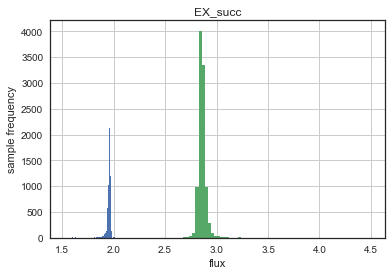

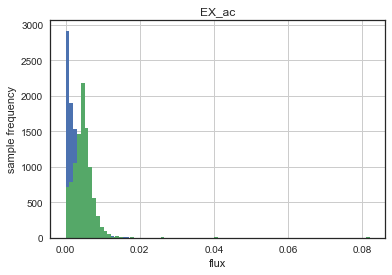

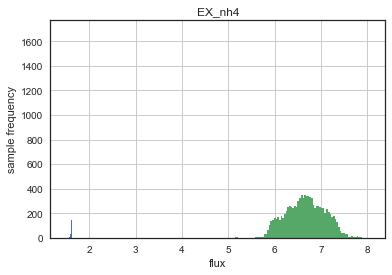

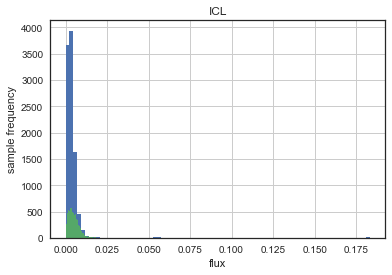

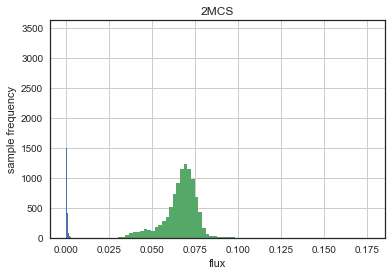

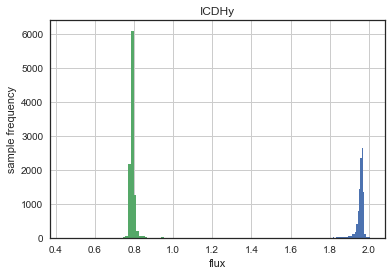

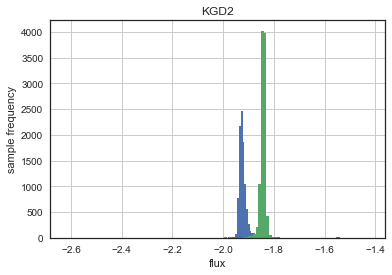

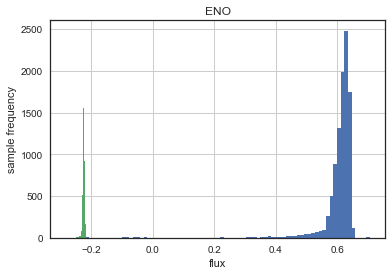

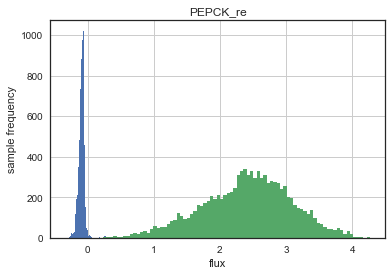

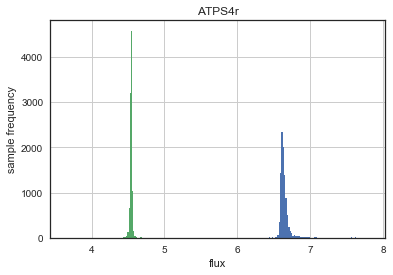

In [69]:
reacts_of_interest = ['EX_succ', 'EX_ac', 'EX_nh4', 'ICL', '2MCS', 'ICDHy','KGD2', 'ENO', 'PEPCK_re', 'ATPS4r']
for react in reacts_of_interest:
    inVitro_samples[react].hist(bins=80)
    inVivo_samples[react].hist(bins=80)
    plt.title(react)
    plt.ylabel("sample frequency")
    plt.xlabel("flux")
    plt.show()

## Box plots of Sampled distributions
These plots are used for **Figure 3** in the main text.

In [70]:
def plot_box_plot(samples1, samples2, name1, name2, rxn, title):
    box_1 = samples1[rxn].copy()
    box_1.name = name1
    box_2 = samples2[rxn].copy()
    box_2.name = name2
    box_df = pd.concat([box_1, box_2], axis=1)
    color = dict(boxes='k', whiskers='k', medians='r', caps='Gray')
    box_df.plot.box(sym='', title=title, color=color)
    plt.ylabel("Flux")
    # save_fig_name = rxn+"_sampling_boxplot_NGAM_1.svg"
    # plt.savefig(save_fig_name)

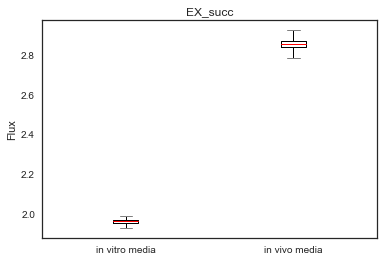

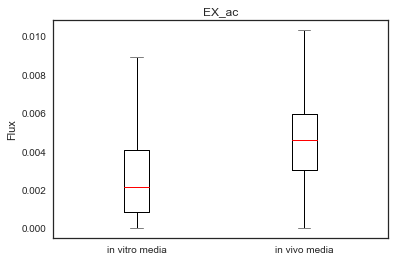

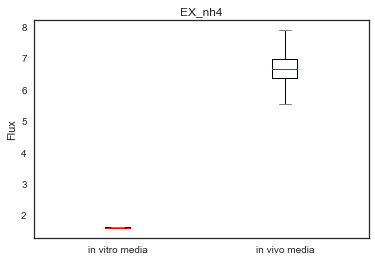

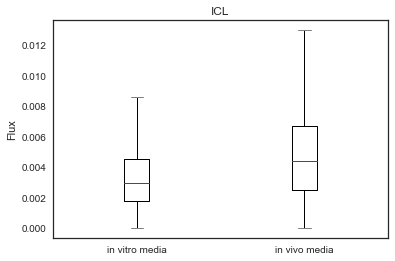

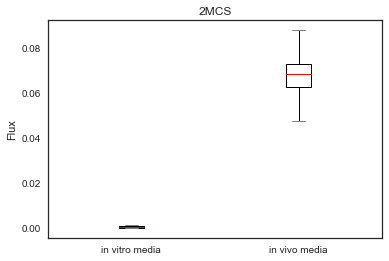

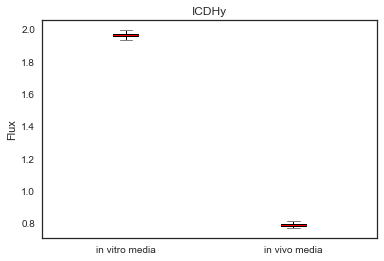

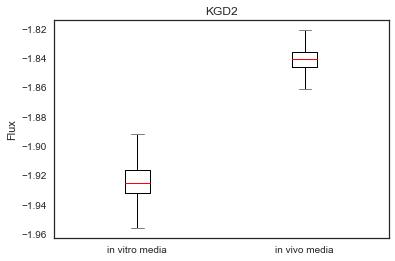

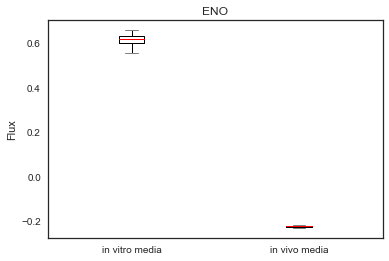

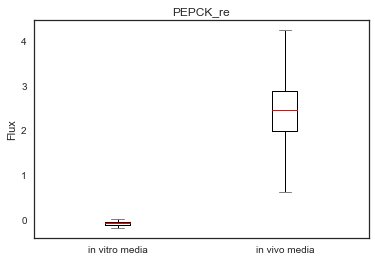

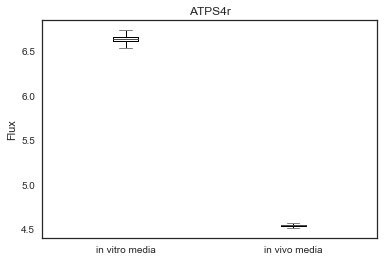

In [71]:
for react in reacts_of_interest:
    plot_box_plot(inVitro_samples, inVivo_samples, 
               "in vitro media", "in vivo media", 
               react, 
               react)

---

# 4. _Curated list of AMR genes for escher map_

<a id='amr_genes'></a>

In [60]:
amr_gene_dic = {
    "EMB": 1000,
    "DCPT": 1000,
    "AFTA": 1000,
    "ALAR": 1000,
    "ALAALAr": 1000,
    "ALAD_L": 1000,
    "GXRA": 1000,
    "CAT": 1000,
    "MYCSacp58": 1000,
    "MYCSacp50": 1000,
    "DCPE": 1000,
    "TMDS": 1000,
    "FOLR2": 1000,
    "APRAUR": 1000,
    "DHPPDA2": 1000,
    "DHFS": 1000,
    "THFGLUS": 1000,
    "NNAM": 1000,
    "CIGAMS": 1000,
    "PDIMAT": 1000,
    "PPDIMAT": 1000
}

with open('amr_gene_dic.json', 'w') as f:
    json.dump(amr_gene_dic, f)

----

# 5. _Comparison of AMR objective functions between media conditions_
1. For either in vivo or in vitro media conditions.
    - For a drug objective.
        - Compute FVA while holding "biomass" flux 20% of max growth (max "biomass" flux)
            - We allow FVA to have solutions within 95% of the objective optimum.
        - Look at the AMR reactions in FVA.
            - these are contained in amr_gene_dic defined above

<a id='amr_objective_simulation'></a>

In [61]:
def metabolite_objective_func(mod1, metab, obj_name):
    """
    Take a metabolite and set it as the objective function.
    """
    mod = mod1.copy()
    metab_drain = Reaction(obj_name)
    metab_drain.lower_bound = 0  # This is the default
    metab_drain.upper_bound = 1000.  # This is the default
    metab_drain.add_metabolites({mod.metabolites.get_by_id(metab): -1.0})
    mod.add_reaction(metab_drain)

    return mod

def add_drugObjectives_model(drug_obj_dic, model):
    """
    Take a dictionary of drug objectives and convert it to objective functions
    
    Returns the model with the reaction set with both upper and lower bounds to 0
    """
    for name, [metab_id, metab_or_react] in drug_obj_dic.iteritems():
        
        print name, [metab_id, metab_or_react]
        
        if metab_or_react == "metabolite":
            model = metabolite_objective_func(model, metab_id, name)
            model.reactions.get_by_id(name).upper_bound = 0
        # If metab_or_react is a reaction, do nothing. We will optimize it later.
            
    return model

In [ ]:
# model_iEK = add_drugObjectives_model(drugObjs, model_iEK)

**drugObjs** - dictionary of approximated objective functions.

In [ ]:
model_iEK = cobra.io.load_json_model(recon_location+"iEK1008_inVivo_media.json")

print "Add demand drain reactions for dead end metabolites"
for rxn_id in ["ncam_c"]: # , "prpp_c", "h2o_c","nac_c"
    drain_name = "DM_"+rxn_id
    react = Reaction(drain_name)
    react.name = rxn_id + " Demand reaction"
    react.subsystem = 'Intracellular demand'
    model_iEK.add_reactions([react])
    react_string = rxn_id + " --> "
    model_iEK.reactions.get_by_id(drain_name).reaction = react_string
    print model_iEK.reactions.get_by_id(drain_name).reaction

# model_iEK.reactions.get_by_id("UPPRT").lower_bound = -1000
# model_iEK.reactions.get_by_id("EX_h2o").lower_bound = -1000
# model_iEK.reactions.get_by_id("DM_nac_c").lower_bound = -1000
    
drugObjs = {
    "ethambutol_obj": ["decda__tb_c", "metabolite"],
    "pas_obj": ["thf_c", "metabolite"],
    "cycloserine_obj": ["ala__L_c", "metabolite"],
    "ethionamide_obj": ["msh_c", "metabolite"],
}

# drugObjs = {
#     "ethambutol_obj": ["decda__tb_c", "metabolite"],
#     "pas_obj": ["thf_c", "metabolite"],
#     "cycloserine_obj": ["ala__L_c", "metabolite"],
#     "ethionamide_obj": ["msh_c", "metabolite"],
#     "pyrazinamide": ["ncam_c", "metabolite"],
# }

model_iEK = add_drugObjectives_model(drugObjs, model_iEK)

In [ ]:
# universal = cobra.Model("universal_reactions")
# with model_iEK:
#     model_iEK.objective = model_iEK.add_boundary(model_iEK.metabolites.ncam_c, type='demand')
#     solution = cobra.flux_analysis.gapfilling.gapfill(model_iEK, universal)
#     for reaction in solution[0]:
#         print(reaction.id)


# model_iEK.reactions.get_by_id("DM_ncam_c").reaction

# # model_iEK.objective = "NNDMBRT"
# model_iEK.objective = "DM_ncam_c"
# model_iEK.optimize().f

# print model_iEK.optimize().fluxes["NAPRTr"]
# print model_iEK.optimize().fluxes["NNAM"]

# print "Add demand drain reactions for dead end metabolites"
# for rxn_id in ["ncam_c",]:
#     drain_name = "DM_"+rxn_id
#     react = Reaction(drain_name)
#     react.name = rxn_id + " Demand reaction"
#     react.subsystem = 'Intracellular demand'
#     model_iEK.add_reactions([react])
#     react_string = rxn_id + " --> "
#     model_iEK.reactions.get_by_id(drain_name).reaction = react_string
#     print model_iEK.reactions.get_by_id(drain_name).reaction

Set the media conditions.

In [ ]:
model_iEK_vivo = cobra.io.load_json_model("iEK1011_inVivo_media.json")
inVivo_media = model_iEK_vivo.medium

model_iEK_vitro = cobra.io.load_json_model("iEK1011_drugTesting_media.json")
inVitro_media = model_iEK_vitro.medium

Compute the FVA dataframes.

In [ ]:
fva_drug_obj_df = pd.DataFrame()
fva_diff_media_df = pd.DataFrame()

for drg_obj in drugObjs.keys():
    
    print drg_obj,
    print model_iEK.reactions.get_by_id(drg_obj).upper_bound, 
    print model_iEK.reactions.get_by_id(drg_obj).reaction
    
    # Compute FVA with the new drug obj in both conditions
    # ----- in vitro -----
    model_iEK.objective = "biomass"
    model_iEK.medium = inVitro_media
    opt_biomass = model_iEK.optimize().f
    model_iEK.reactions.get_by_id("biomass").lower_bound = 0.2*opt_biomass
    
    # Maximize the drug objective!
    model_iEK.objective = drg_obj
    model_iEK.reactions.get_by_id(drg_obj).upper_bound = 1000
    
    fva_vitro = cobra.flux_analysis.flux_variability_analysis(model_iEK,
                                                        fraction_of_optimum=.95, 
                                                        solver=None)
    fva_vitro_df = pd.DataFrame.from_dict(fva_vitro).round(5)
    
    # change back lower bound of biomass reaction to 0
    model_iEK.reactions.get_by_id("biomass").lower_bound = 0 
    
    # ----- in Vivo -----
    model_iEK.objective = "biomass"
    model_iEK.medium = inVivo_media
    opt_biomass = model_iEK.optimize().f
    model_iEK.reactions.get_by_id("biomass").lower_bound = 0.2*opt_biomass
    
    # Maximize the drug objective!
    model_iEK.objective = drg_obj
    model_iEK.reactions.get_by_id(drg_obj).upper_bound = 1000
    
    fva_vivo = cobra.flux_analysis.flux_variability_analysis(model_iEK,
                                                        fraction_of_optimum=.95, 
                                                        solver=None)
    fva_vivo_df = pd.DataFrame.from_dict(fva_vivo).round(5)
    
    # change back lower bound of biomass reaction to 0
    model_iEK.reactions.get_by_id("biomass").lower_bound = 0 
    
    # fva_vitro_minus_vivo_diff
    fva_vitro_minus_vivo_diff = fva_vitro_df - fva_vivo_df
    fva_vitro_minus_vivo_diff.columns = ["max_diff_"+drg_obj, "min_diff_"+drg_obj]
    
    fva_vitro_df.columns = ["max_vitro_"+drg_obj, "min_vitro_"+drg_obj]
    fva_vivo_df.columns = ["max_vivo_"+drg_obj, "min_vivo_"+drg_obj]
    
    # Set the reaction bound back to 0
    model_iEK.reactions.get_by_id(drg_obj).upper_bound = 0
    
    new_df = pd.concat([fva_vitro_df, fva_vivo_df], axis=1)
    fva_drug_obj_df = pd.concat([fva_drug_obj_df, new_df], axis=1)
    fva_diff_media_df = pd.concat([fva_diff_media_df, fva_vitro_minus_vivo_diff], axis=1)
    
# set iEK objective back to biomass
model_iEK.objective = "biomass"

# only get major reactions.
fva_drug_obj_AMRfilt_df = fva_drug_obj_df.copy().loc[amr_gene_dic, :]
fva_diff_media_AMRfilt_df = fva_diff_media_df.copy().loc[amr_gene_dic, :]

#### FVA max

In [ ]:
invivo_cols, invitro_cols = [], []
for x in fva_drug_obj_AMRfilt_df.columns:
    if "max_vivo" in x:
        invivo_cols.append(x)
    elif "max_vitro" in x:
        invitro_cols.append(x)
        
fva_drug_Vivofilt_df = fva_drug_obj_AMRfilt_df.copy().loc[:,invivo_cols]
fva_drug_Vitrofilt_df = fva_drug_obj_AMRfilt_df.copy().loc[:,invitro_cols]

drop_rows = []
for index, row in fva_drug_Vivofilt_df.iterrows():
    if row.sum()==0:
        drop_rows.append(index)
    elif sum(row/row.max())==4:
        drop_rows.append(index)

fva_drug_Vivofilt_df.drop(drop_rows,axis=0, inplace=True)

drop_rows = []
for index, row in fva_drug_Vitrofilt_df.iterrows():
    if row.sum()==0:
        drop_rows.append(index)
    elif sum(row/row.max())==4:
        drop_rows.append(index)
fva_drug_Vitrofilt_df.drop(drop_rows,axis=0, inplace=True)

In [ ]:
g = sns.clustermap(fva_drug_Vivofilt_df.T, z_score=True, row_cluster=False, col_cluster=False)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
# plt.savefig("fva_drug_VIVO.svg")

In [ ]:
g = sns.clustermap(fva_drug_Vitrofilt_df.T, z_score=True, row_cluster=False, col_cluster=False)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
# plt.savefig("fva_drug_VITRO.svg")

### FVA min

In [ ]:
invivo_cols, invitro_cols = [], []
for x in fva_drug_obj_AMRfilt_df.columns:
    if "min_vivo" in x:
        invivo_cols.append(x)
    elif "min_vitro" in x:
        invitro_cols.append(x)
        
fva_drug_Vivofilt_df = fva_drug_obj_AMRfilt_df.copy().loc[:,invivo_cols]
fva_drug_Vitrofilt_df = fva_drug_obj_AMRfilt_df.copy().loc[:,invitro_cols]

drop_rows = []
for index, row in fva_drug_Vivofilt_df.iterrows():
    if row.sum()==0:
        drop_rows.append(index)
    elif sum(row/row.max())==4:
        drop_rows.append(index)

fva_drug_Vivofilt_df.drop(drop_rows,axis=0, inplace=True)

drop_rows = []
for index, row in fva_drug_Vitrofilt_df.iterrows():
    if row.sum()==0:
        drop_rows.append(index)
    elif sum(row/row.max())==4:
        drop_rows.append(index)
fva_drug_Vitrofilt_df.drop(drop_rows,axis=0, inplace=True)

###  ~~Kendall correlation matrix for FVA drug objectives between in vivo and in vitro conditions~~

In [ ]:
#### in vivo conditions

sns.set(font_scale=2)

drop_rows = []
for index, row in fva_drug_Vivofilt_df.iterrows():
    if row.sum()==0:
        drop_rows.append(index)
    elif sum(row/row.max())==4:
        drop_rows.append(index)
#     elif row.sum()>1000:
#         drop_rows.append(index)
fva_drug_Vivofilt_df.drop(drop_rows,axis=0, inplace=True)

fva_drug_vivo_corr = fva_drug_Vivofilt_df.T.corr(method="kendall")


g = sns.clustermap(fva_drug_vivo_corr, z_score=True)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
# plt.savefig("fva_drug_VIVO_kendallclustermap.svg")




#### in vitro conditions

drop_rows = []
for index, row in fva_drug_Vitrofilt_df.iterrows():
    if row.sum()==0:
        drop_rows.append(index)
    elif sum(row/row.max())==4:
        drop_rows.append(index)
fva_drug_Vitrofilt_df.drop(drop_rows,axis=0, inplace=True)

fva_drug_vitro_corr = fva_drug_Vitrofilt_df.T.corr(method="kendall")

# %matplotlib inline
# sns.heatmap(fva_drug_vivo_corr)

g = sns.clustermap(fva_drug_vitro_corr)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
# plt.savefig("fva_drug_VITRO_kendallclustermap.svg")

----

# 6. _Output to excel sheet._

- Simulations above for fva_norm and fva_hypox must be run above to run the output code below.
- Simulations above for fva_drug_vitro and fva_drug_vivo must be run above as well.

Prepare _iEK1011_ reaction and metabolite sheets. The gene sheet with references was manually generated.

<a id='save_model_to_supplementary'></a>

#### Map references from other models to excel.

In [ ]:
sMtb_react_ids = [x.id for x in model_sMtb_mapped.reactions]
iEKold_react_ids = [x.id for x in model_iEK1032old.reactions]
iOSDD_react_ids = [x.id for x in model_iOSDD.reactions]
iSM810_react_ids = [x.id for x in model_iSM810.reactions]

iEK_to_reference = {}

for react in model_iEK.reactions:
    
    react_id = react.id
    react_name = react.name
    react_gpr = react.gene_reaction_rule
    
    iEK_to_reference.update({react_id: []})
    
    if react_id in sMtb_react_ids:
        iEK_to_reference[react_id].append("sMtb")
        
    if react_id in sMtb_react_ids:
        iEK_to_reference[react_id].append("iEKold")
        
    if react_id in iOSDD_react_ids:
        iEK_to_reference[react_id].append("iOSDD")


iEK_TRUE_reference = {}
no_models_ref = {}

for react, model_list in iEK_to_reference.iteritems():
    
    if len(model_list) != 0:
        iEK_gpr = model_iEK.reactions.get_by_id(react).gene_reaction_rule
        
        for m in model_list:
            
            new_gpr = '--'
            m_ref = '--'
            
            if m == "sMtb":
                new_gpr = model_sMtb_mapped.reactions.get_by_id(react).gene_reaction_rule
                m_ref = "sMtb: Rienksma et al. 2014"
                
            if m == "iOSDD":
                new_gpr = model_iOSDD.reactions.get_by_id(react).gene_reaction_rule
                m_ref = "iOSDD: Vashisht et al. 2014"
                
            if m == "iEKold":
                new_gpr = model_iEK1032old.reactions.get_by_id(react).gene_reaction_rule
                m_ref = "BioCyc DB 20.0: Caspi et al. 2016"
        
            if iEK_gpr == new_gpr:
                
                if react not in iEK_TRUE_reference.keys():
                    iEK_TRUE_reference.update({react: [m_ref]})
                else:
                    iEK_TRUE_reference[react].append(m_ref)
    
    else:
        if str(react[:3]) == "EX_":
            iEK_TRUE_reference.update({react: ["No reference: Exchange reaction"]})
        else:
            no_models_ref.update({react: "No ref"})

manual_ref= {u'3HBCOAHL': 'sMtb: Rienksma et al. 2014',
             u'ACONMT': 'BioCyc DB 20.0: Caspi et al. 2016',
             u'AKGDH': '',
             u'AKGDa': 'sMtb: Rienksma et al. 2014',
             u'APSR': 'iOSDD: Vashisht et al. 2014',
             u'ATPM': '',
             u'CYSK2_I': 'Steiner et al. 2014',
             u'CYSM_I': 'Agren et al. 2008',
             u'CYSM_II': 'Agren et al. 2008',
             u'CYSO_I': 'Burns et al. 2005',
             u'CYSO_II': 'Burns et al. 2005',
             u'DGTP8DETOX': 'BioCyc Database 20.0',
             u'DGTP8OXO': 'BioCyc Database 20.0',
             u'DM_EX_pc_TB': 'Artificial Drain',
             u'DM_cpppg1_c': 'Artificial Drain',
             u'DM_ergoth_c': 'Artificial Drain',
             u'DM_gmhep1p_c': 'Artificial Drain',
             u'DM_isotbsinol__13R_c': 'Artificial Drain',
             u'DM_isotbsinol__13S_c': 'Artificial Drain',
             u'DM_psd5p_c': 'Artificial Drain',
             u'DM_scys__L_c': 'Artificial Drain',
             u'DM_tbsinol_c': 'Artificial Drain',
             u'EGTB': 'Richard-Greenblatt et al. 2015',
             u'EGTC': 'Richard-Greenblatt et al. 2015',
             u'EGTD': 'Richard-Greenblatt et al. 2015',
             u'EGTE': 'Richard-Greenblatt et al. 2015',
             u'EPH': 'BioCyc Database 20.0',
             u'GMHEPK': 'iOSDD: Vashisht et al. 2014',
             u'GMHEPPA': 'iOSDD: Vashisht et al. 2014',
             u'GTP8OXO': 'BioCyc Database 20.0',
             u'GXRA': 'Michelle M. Griffin et al. 2012',
             u'MAK': 'Ma et al. 2015',
             u'MANPGH': 'BioCyc Database 20.0',
             u'MHUD1': 'Nambu et al. 2013',
             u'NODCOAt': '',
             u'OCTSCOAt': '',
             u'PHEMEt': 'Tillius et al 2011',
             u'ROSFE': 'BioCyc Database 20.0',
             u'TBSNLS1': 'Layre et al. 2014',
             u'TBSNLS2': 'Layre et al. 2014',
             u'TBSNLS3': 'Layre et al. 2014',
             u'TBSYNLDPS': 'Layre et al. 2014',
             u'VPAMTr': '',
             u'biomass': ''}
print len(iEK_TRUE_reference.keys())

In [ ]:
model_iEK = cobra.io.load_json_model("iEK1011_m7H10_media.json")
print model_iEK.medium
react_dict = []
for react in model_iEK.reactions:
    
    if len(react.name)==0:
        react_name = str(react.id)
    else:
        react_name = str(react.name)
        
    if str(react.id) in iEK_TRUE_reference.keys():
        references = iEK_TRUE_reference[react.id]
        references = ", ".join(references)
    elif str(react.id) in manual_ref.keys():
        references = manual_ref[react.id]
        
    
    react_dict.append({'Reaction ID': str(react.id), 
                       'Reaction Name': react_name, 
                       'Subsystem': str(react.subsystem), 
                       'Reaction Formula': str(react.reaction),
                       'Lower Bound': str(react.lower_bound),
                       'Upper Bound': str(react.upper_bound),
                       'Gene Reaction Rule': str(react.gene_reaction_rule),
                       'Reaction Reference': references
                 })
react_df = pd.DataFrame(react_dict)
react_df = react_df[["Reaction ID", 'Reaction Name', 'Subsystem', 'Reaction Formula', 
                     'Lower Bound', 'Upper Bound', 'Gene Reaction Rule', 'Reaction Reference' ]]

metab_dict = []
for metab in model_iEK.metabolites:
    
    metab_dict.append({'Metabolite ID': str(metab.id), 
                       'Metabolite Name': str(metab.name), 
                       'Metabolite Formula': str(metab.formula), 
                 })
metab_df = pd.DataFrame(metab_dict)
metab_df = metab_df[["Metabolite ID", 'Metabolite Name', 'Metabolite Formula']]

Prepare Griffin Essentiality sheet.

In [ ]:
model_iEK = cobra.io.load_json_model("iEK1011_griffinEssen_media.json")
griffin_media = model_iEK.medium
FN_dic, FP_dic, TN_dic, TP_dic = essen_test(model_iEK, "Yes both", "griffin", griffin_excel, grow_thresh)

gene_essential_dic = []
for gene in model_iEK.genes:
    g = str(gene)
    if g in FN_dic.keys():
        ko_growth_rate = FN_dic[g][0]
        griff_p_val = FN_dic[g][1]
        error_type = "False Negative"
    if g in FP_dic.keys():
        ko_growth_rate = FP_dic[g][0]
        griff_p_val = FP_dic[g][1]
        error_type = "False Positive"
    if g in TN_dic.keys():
        ko_growth_rate = TN_dic[g][0]
        griff_p_val = TN_dic[g][1]
        error_type = "True Negative"
    if g in TP_dic.keys():
        ko_growth_rate = TP_dic[g][0]
        griff_p_val = TP_dic[g][1]
        error_type = "True Positive"
    gene_essential_dic.append({"Gene": g, 
                               "KO Growth Rate": ko_growth_rate, 
                               "Griffin Essentiality P-Value": griff_p_val,
                               "Error Type": error_type
                              })
    
gene_griffin_essen_df = pd.DataFrame(gene_essential_dic)
gene_griffin_essen_df = gene_griffin_essen_df[["Gene", "KO Growth Rate", "Griffin Essentiality P-Value", "Error Type"]]
gene_griffin_essen_df.head()

Perform accuracy computation for Griffin dataset for shared 472 genes.

In [ ]:
model_iEK = cobra.io.load_json_model("iEK1011_griffinEssen_media.json")
griffin_media = model_iEK.medium
FN_dic_iEK, FP_dic_iEK, TN_dic_iEK, TP_dic_iEK = essen_test(model_iEK, "Yes both", "griffin", griffin_excel, grow_thresh)

gene_essential_dic = []
for gene in model_iEK.genes:
    g = str(gene)
    if g in FN_dic.keys():
        ko_growth_rate = FN_dic[g][0]
        griff_p_val = FN_dic[g][1]
        error_type = "False Negative"
    if g in FP_dic.keys():
        ko_growth_rate = FP_dic[g][0]
        griff_p_val = FP_dic[g][1]
        error_type = "False Positive"
    if g in TN_dic.keys():
        ko_growth_rate = TN_dic[g][0]
        griff_p_val = TN_dic[g][1]
        error_type = "True Negative"
    if g in TP_dic.keys():
        ko_growth_rate = TP_dic[g][0]
        griff_p_val = TP_dic[g][1]
        error_type = "True Positive"
    gene_essential_dic.append({"Gene": g, 
                               "KO Growth Rate": ko_growth_rate, 
                               "Griffin Essentiality P-Value": griff_p_val,
                               "Error Type": error_type
                              })
    
shared_gene_griffin_essen_df = pd.DataFrame(gene_essential_dic)
shared_gene_griffin_essen_df = gene_griffin_essen_df[["Gene", "KO Growth Rate", "Griffin Essentiality P-Value", "Error Type"]]
shared_gene_griffin_essen_df.head()

Prepare DeJesus Essentiality dataset

In [ ]:
model_iEK = cobra.io.load_json_model("iEK1011_deJesusEssen_media.json")
deJesus_media = model_iEK.medium
FN_dic_iEK, FP_dic, TN_dic, TP_dic = essen_test(model_iEK, "Yes both", "loerger", loerger_excel, grow_thresh)

gene_essential_dic = []
for gene in model_iEK.genes:
    g = str(gene)
    if g in FN_dic.keys():
        ko_growth_rate = FN_dic[g][0]
        error_type = "False Negative"
    if g in FP_dic.keys():
        ko_growth_rate = FP_dic[g][0]
        error_type = "False Positive"
    if g in TN_dic.keys():
        ko_growth_rate = TN_dic[g][0]
        error_type = "True Negative"
    if g in TP_dic.keys():
        ko_growth_rate = TP_dic[g][0]
        error_type = "True Positive"
    gene_essential_dic.append({"Gene": g, 
                               "KO Growth Rate": ko_growth_rate, 
                               "Error Type": error_type
                              })
    
gene_deJesus_essen_df = pd.DataFrame(gene_essential_dic)
gene_deJesus_essen_df = gene_deJesus_essen_df[["Gene", "KO Growth Rate", "Error Type"]]
gene_deJesus_essen_df.head()

Perform accuracy computation for shared 472 genes in deJesus

In [ ]:
model_iEK = cobra.io.load_json_model("iEK1011_deJesusEssen_media.json")
deJesus_media = model_iEK.medium
FN_dic_iEK, FP_dic_iEK, TN_dic, TP_dic = essen_test_sharedGenes(model_iEK, "Yes both", "loerger", loerger_excel, grow_thresh, all_shared_genes)

gene_essential_dic = []
for gene in model_iEK.genes:
    g = str(gene)
    if g in FN_dic.keys():
        ko_growth_rate = FN_dic[g][0]
        error_type = "False Negative"
    if g in FP_dic.keys():
        ko_growth_rate = FP_dic[g][0]
        error_type = "False Positive"
    if g in TN_dic.keys():
        ko_growth_rate = TN_dic[g][0]
        error_type = "True Negative"
    if g in TP_dic.keys():
        ko_growth_rate = TP_dic[g][0]
        error_type = "True Positive"
    gene_essential_dic.append({"Gene": g, 
                               "KO Growth Rate": ko_growth_rate, 
                               "Error Type": error_type
                              })
    
shared_gene_deJesus_essen_df = pd.DataFrame(gene_essential_dic)
shared_gene_deJesus_essen_df = shared_gene_deJesus_essen_df[["Gene", "KO Growth Rate", "Error Type"]]
shared_gene_deJesus_essen_df.head()

Prepare media conditions as JSON files.

In [ ]:
model_iEK_vivo = cobra.io.load_json_model("iEK1011_inVivo_media.json")
inVivo_conditions = model_iEK_vivo.medium

model_iEK_vitro = cobra.io.load_json_model("iEK1011_drugTesting_media.json")
inVitro_drugTesting = model_iEK_vitro.medium

model_iEK = cobra.io.load_json_model("iEK1011_m7H10_media.json")

In [ ]:
media_conditions = [model_iEK.medium, griffin_media, deJesus_media, inVitro_drugTesting, inVivo_conditions]
media_df = pd.DataFrame(media_conditions)
media_df = media_df.transpose()
media_df.columns = ["Middlebrook m7H10 (Acetate C-source)", 
                    "Griffin Media (Gene Essentiality)", 
                    "deJesus Media (Gene Essentiality)",
                    "Lowenstein-Jensen Media (Drug-Testing)", 
                    "Physiological Media (in vivo modeling)"]
media_df.head()

### Blocked reactions dataframe

In [ ]:
blocked_reacts_df = pd.DataFrame(blocked_reacts, columns=["blocked reactions"])
blocked_reacts_df["subsystem"] = blocked_reacts_df["blocked reactions"].map(lambda x: model_iEK.reactions.get_by_id(x).subsystem)

# Counter(list(blocked_reacts_df["subsystem"])).most_common()

blocked_reacts_df["subsystem"].hist(xrot=90, xlabelsize=10,bins=100)

### Comparison of model essentiality predictions

In [ ]:
FP_all_models_Griffin = list(FP_dic_iEK.keys()+FP_dic_sMtb.keys()+FP_dic_iSM810.keys()+FP_dic_iOSDD.keys())
FP_all_models_Griffin = [x[0] for x in Counter(FP_all_models_Griffin).most_common() if x[1]>3]

FN_all_models_Griffin = list(FN_dic_iEK.keys()+FN_dic_sMtb.keys()+FN_dic_iSM810.keys()+FN_dic_iOSDD.keys())
FN_all_models_Griffin = [x[0] for x in Counter(FN_all_models_Griffin).most_common() if x[1]>3]

all_model_FN_FP = {}
subsystemz = []
for x in list(set(FP_all_models_Griffin+FN_all_models_Griffin)):
    all_model_FN_FP[x] = []
    for y in model_iEK.genes.get_by_id(x).reactions:
        all_model_FN_FP[x].extend([(y.id, y.subsystem)])
        subsystemz.append(str(y.subsystem))
print len(all_model_FN_FP)


FP_iEK_wrong_sMtb_right = {}
subsystemz = []
for x in FP_dic_iEK.keys():
    if x in sMtb_genes and x not in FP_dic_sMtb.keys() and x not in FN_dic_sMtb.keys():
        # FP_iEK_wrong_sMtb_right.append(x)
        FP_iEK_wrong_sMtb_right[x] = []
        for y in model_iEK.genes.get_by_id(x).reactions:
            FP_iEK_wrong_sMtb_right[x].extend([(y.id, y.subsystem)])
            subsystemz.append(str(y.subsystem))
print len(FP_iEK_wrong_sMtb_right)

TN_iEK_right_sMtb_wrong = {}
subsystemz = []
for x in TN_dic_iEK.keys():
    if x in sMtb_genes and x not in TN_dic_sMtb.keys() and x not in TP_dic_sMtb.keys():
        # FP_iEK_wrong_sMtb_right.append(x)
        TN_iEK_right_sMtb_wrong[x] = []
        for y in model_iEK.genes.get_by_id(x).reactions:
            TN_iEK_right_sMtb_wrong[x].extend([(y.id, y.subsystem)])
            subsystemz.append(str(y.subsystem))
print len(TN_iEK_right_sMtb_wrong)

In [ ]:
FP_FN_all_models_df = pd.DataFrame.from_dict(all_model_FN_FP.items())
FP_FN_all_models_df.columns = ["Gene", "Pathway"]

FP_iEK_wrong_sMtb_right_df = pd.DataFrame.from_dict(FP_iEK_wrong_sMtb_right.items())
FP_iEK_wrong_sMtb_right_df.columns = ["Gene", "Pathway"]

TN_iEK_right_sMtb_wrong_df = pd.DataFrame.from_dict(TN_iEK_right_sMtb_wrong.items())
TN_iEK_right_sMtb_wrong_df.columns = ["Gene", "Pathway"]

In [ ]:
cobra.__version__

In [ ]:
get_models_gene_info("Rv0437c")

Write everything to excel file.

In [ ]:
writer = pd.ExcelWriter('iEK1011_supplementary.xlsx')
react_df.to_excel(writer, sheet_name='Reactions', index=False)
metab_df.to_excel(writer, sheet_name='Metabolites', index=False)
genes_notiEK_inPrevious_df.to_excel(writer, sheet_name='Removed genes other models', index=True)
gene_griffin_essen_df.to_excel(writer, sheet_name="Gene Essentiality Griffin", index=False)
gene_deJesus_essen_df.to_excel(writer, sheet_name="Gene Essentiality deJesus", index=False)
media_df.to_excel(writer, sheet_name="Media Conditions", index=True)
fva_norm.T.to_excel(writer, sheet_name="FVA in vitro conditions", index=True)
fva_hypox.T.to_excel(writer, sheet_name="FVA in vivo conditions", index=True)
fva_drug_Vitrofilt_df.to_excel(writer, sheet_name='AMR objective Max Flux in vitro', index=True)
fva_drug_Vivofilt_df.to_excel(writer, sheet_name='AMR objective Max Flux in vivo', index=True)

shared_gene_griffin_essen_df.to_excel(writer, sheet_name="Shared Essentiality Griffin", index=False)
shared_gene_deJesus_essen_df.to_excel(writer, sheet_name="Shared Essentiality deJesus", index=False)

blocked_reacts_df.to_excel(writer, sheet_name="Blocked Reactions", index=False)

FP_FN_all_models_df.to_excel(writer, sheet_name="All models incorrect", index=False)
FP_iEK_wrong_sMtb_right_df.to_excel(writer, sheet_name="iEK Wrong and sMtb Correct", index=False)
TN_iEK_right_sMtb_wrong_df.to_excel(writer, sheet_name="iEK Correct and sMtb Wrong", index=False)

writer.save()

# The end.